$$\newcommand{\fudm}[2]{\frac{\mathrm{D} #1}{\mathrm{D} #2}}
\newcommand{\pad}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ppad}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\ppadd}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}
\newcommand{\nnabla}{\nabla^2}
\newcommand{\eps}{\epsilon}
\newcommand{\vdetail}[1]{\vb{#1}=\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\vb}[1]{\mathbf{#1}}
\newcommand{\va}[1]{\vec{#1}}
\newcommand{\tb}[1]{\underline{\underline{\mathbf{#1}}}}
\newcommand{\fud}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}$$

# Medical Ultrasound 2

## Bioeffects from ultrasound imaging 
Since 1992 ultrasound imaging systems are regulated to display two indices to account for potential bioffects from heating and cavitation (activation of gaseous nuclei). The ultrasonic scanners must show in real time the thermal indidces (TIs) and the mechanical index (MI) which is a function of the operation mode of the US scanner.

## Mechanical index

The mechanical index, MI, in ultrasound imaging is defined as

\begin{equation}
\mathrm{MI}=\frac{\mathrm{PNP}}{\sqrt{f_c}}\tag{9.1}
\end{equation}

where PNP is the peak negative pressure in MPa at the position of imaging and $f_c$ is the center frequency of the imaging device in MHz.

For an MI < 0.3 the acoustic amplitude is considered low, for 0.3 < MI < 0.7 there is a possibility of minor damage to neonatal lung or intestine. Above MI > 0.7 there is a theoretical risk of cavitation. Medical US scanners are limited to an MI of 1.9 for imaging.




### Rayleigh Plesset Equation

The Rayleigh Plesset Equation (without viscous dissipation) is given by Eq. (9.2):
\begin{equation}
R \ddot{R} +\frac{3}{2} \dot{R}^2=\frac{p_v-p_\infty(t)}{\rho}+\frac{p_{g0}}{\rho}\left(\frac{R_0}{R}\right)^{3\kappa}-\frac{2\sigma}{\rho R}\label{9.2}\tag{9.2}
\end{equation}
The driving of the bubble occurs through the pressure $p_\infty(t)$ term. This could be for example through a harmonic driving $p_\infty(t)=p_0 + p_a \sin (\omega t)$ where $\omega$ is the angular frequency, $p_0$ the static pressure, and $p_a$ the amplitude of the driving.

We want to solve this equation for small and large oscillations, i.e. for small and large pressures $p_a$. To do so we first define the constants for an air bubble in water at room temperature undergoing isothermal compression.

The gas pressure at equilibrium is given by the equilibrium condition

\begin{equation}
p_v+p_{g0}=p_\infty+\frac{2\sigma}{R}\label{9.3}\tag{9.3}
\end{equation}

We can solve this nonlinear ODE with the built in solver in python. Therefore, we have to rephrase the 2nd Order ODE into two first order ODEs by variable substitution:

\begin{eqnarray}
y_0&=&R\\
y_1&=&\dot{R}
\end{eqnarray}

\begin{equation}
\dot{R}=\frac{dy_0}{dt}=y_1\label{9.4}\tag{9.4}
\end{equation}
and using the Rayleigh Equation we obtain:
\begin{equation}
\ddot{R}=\frac{dy_1}{dt}=\frac{1}{y_0}\left[
\frac{p_v-p_\infty(t)}{\rho}+\frac{p_g0}{\rho}\left(\frac{R_0}{y_0}\right)^{3\kappa}-\frac{2\sigma}{\rho y_0}-\frac{3}{2}(y_1)^2
\right]\label{9.5}\tag{9.5}
\end{equation}

We use a slightly modified version of the equation by introducing additionally some dissipation from viscosity of the liquid. This term is added on thr R.H.S of Eq. (9.5) which is $-4\mu\dot{R}{R}^{-1}$.

These two first order ODEs are defined in the function `rp(t,y)`

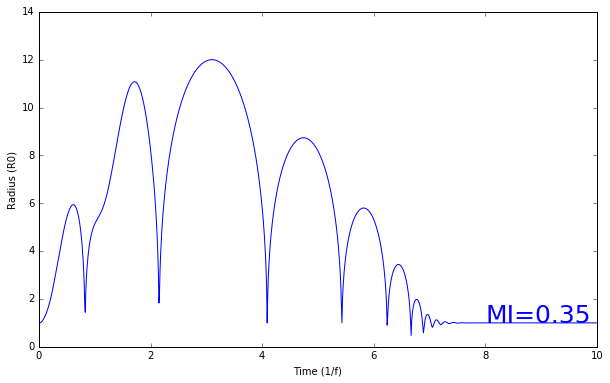

In [10]:
%matplotlib inline 
import numpy as np #work with arrays
from scipy import integrate
#from scipy.integrate import odeint
from matplotlib.pylab import *
from IPython import display
from ipywidgets import widgets

global f, pa, R0, ncycles

pv=2.3388e3     #[Pa] vapour pressure of water
sigma=0.072     #[N/m] coefficient of surface tension between air and water
rho=998.        #[kg/m^3] density of water
kappa=1.4       #polytropic exponent of the gas
p0=1e5          #[Pa] static pressure
nu=1e-6         #[m^2/s]

#Rayleigh Plesset Equation
def rp(t,y):
    global f, pa, R0, ncycles
    pinfty=p0-pa*np.sin(f*2.*np.pi*t)*((ncycles/f)>t)
    pg0=p0+2.*sigma/R0-pv
    dydt0=y[1]
    dydt1=(pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
           -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
           -4.*nu*y[1]/y[0]/y[0]
    return [dydt0,dydt1]

def plotall(newvalue):
    global f
    global pa
    global R0
    global ncycles
    
    #set the variables according to the user input
    f=w_frequency.value*1.e6
    pa=w_pressure.value*1.e5
    R0=w_R0.value*1.e-6
    ncycles=float(w_ncycles.value)
    
    #Setting initial conditions
    t_sim=10./f
    delta_t = t_sim/1000.
    num_steps = int(t_sim/delta_t) + 3
    time = np.zeros((num_steps, 1))
    R = np.zeros((num_steps, 1))
    time[0] = 0.
    R[0] = R0

    ode15s = integrate.ode(rp)
    ode15s.set_initial_value([R[0],0.], 0.)
    
    #Integrate Rayleigh Plesset Equation and store the results every dt
    k = 1
    while ode15s.successful() and ode15s.t < (t_sim):
        ode15s.integrate(ode15s.t+delta_t)
        time[k] = ode15s.t
        R[k] = ode15s.y[0]
        k += 1
        
    #Plotting
    plt.figure(1, figsize=(10, 6), dpi=200)
    plt.clf
    plt.plot(time[0:k-1]*f,R[0:k-1]/R0);
    plt.xlabel('Time (1/f)')
    plt.ylabel('Radius (R0)')
    plt.text(time[k-1]*f*.8,1.,\
             'MI={0:.2f}'.format(pa/1e6/np.sqrt(f/1e6)),\
             fontsize=25,color='b')

    display.clear_output(wait=True)
    
#Userinterface    
w_frequency=widgets.FloatSlider(min=.5,max=20,step=.25,\
                                       value=5,description='Frequency (MHz):')
w_pressure=widgets.FloatSlider(min=.1,max=30,step=.1,\
                                       value=.4,description='Acoustic amplitude (bar):')
w_R0=widgets.FloatSlider(min=.1,max=5,step=.1,\
                                       value=.3,description='Nucleus size (micrometer):')
w_ncycles=widgets.IntSlider(min=1,max=10,step=1,\
                                       value=1,description='Number of cyles')
w_frequency.observe(plotall, names='value') #auto update
w_pressure.observe(plotall, names='value') 
w_R0.observe(plotall, names='value')
w_ncycles.observe(plotall, names='value')
display.display(w_frequency)
display.display(w_pressure)
display.display(w_R0)
display.display(w_ncycles)
plotall(1)

## Thermal index

The thermal indes is defined as

\begin{equation}
\mathrm{TI}=\frac{W_0}{W_{deg}}\label{9.6}\tag{9.6}
\end{equation}

where $W_0$ is the time-averaged acoustic power of the source and $W_{deg}$ is the power necessary to increase the target tissue by $1^\circ$C.  Three commonly used thermal indices are the thermal index of soft tissue (TIS), the thermal index of bone (TIB) and the thermal index of cranial bone (TIC). Recommendation is that at a TI value of 2.0 the examination should not exceed 60 min, while at a TI of 3.0 the duration should be reduced to 15 min.


## High Intensity Focused Ultrasound

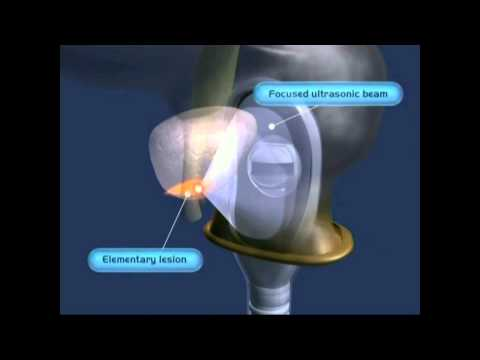

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("NI5UobguS2E",width=800, height=600)

A general introduction is available [here](http://www.myvmc.com/treatments/high-intensity-focused-ultrasound-hifu).

## Histotripsy


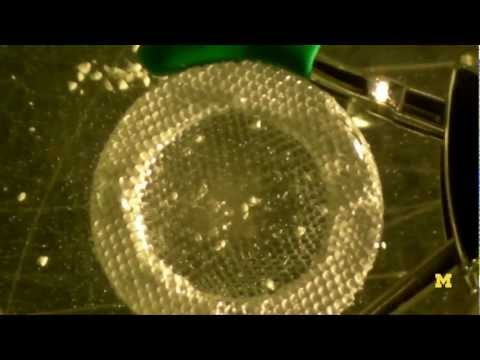

In [9]:
YouTubeVideo("WqZLkzdNYuI",width=800, height=600)

A general introduction is available [here](./pdfs/histotripsy.pdf) and a website with ample information is available [here](http://www.histotripsy.umich.edu)

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom2.css", "r").read()
    return HTML(styles)
css_styling()